# Download data

In [53]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !wget -P /content/ 'https://archive.ics.uci.edu/ml/machine-learning-databases/00495/data.zip'

In [ ]:
# !unzip "/content/data.zip" -d "/content/"

In [3]:
# !rm "/content/data.zip"

# Preprocessing

In [4]:
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

In [5]:
def split_data(acc, ppg, label, ratio = 0.8):
  acc, ppg, label = np.array(acc), np.array(ppg), np.array(label)
  index = np.arange(len(acc))
  np.random.shuffle(index)
  t_index, v_index = index[: int(ratio * len(acc))], index[int(ratio * len(acc)):]
  acc_t, ppg_t = acc[t_index], ppg[t_index]
  acc_v, ppg_v = acc[v_index], ppg[v_index]
  label_t, label_v = label[t_index], label[v_index]
  return acc_t, ppg_t, label_t,  acc_v, ppg_v, label_v
def padding(signal, data):
  if signal == 'acc':
    data = data.reshape((len(data), 1))
    if len(data) < 256:
      padd = np.zeros((256 - len(data), 1))
      data = np.concatenate((data, padd))
      # data = data.reshape((256, 1))
    else: data = data.reshape((256, 1))
  if signal == 'ppg':
    data = data.reshape((len(data), 1))
    if len(data) < 512:
      padd = np.zeros((512 - len(data), 1))
      data = np.concatenate((data, padd))
      # data = data.reshape((512, 1))
    else: data = data.reshape((512, 1))
  return data

In [ ]:
ppg_sample_rate, acc_sample_rate = 64, 32
names = ['S' + str(i) for i in range(1, 2)]
new_ppg, new_acc = list(), list()
for name in names:
  file_path = '/content/PPG_FieldStudy/' + name + '/'
  file_name = name + '.pkl'
  print(file_name + " was read ")
  with open(os.path.join(file_path, file_name), 'rb') as f:
    data = pickle.load(f, encoding = 'latin-1')
  signal, label = data['signal']['wrist'], data['label']
  print('len of label is : ', len(label))
  acc, ppg = signal['ACC'], signal['BVP']
  scale = MinMaxScaler()
  acc, ppg = scale.fit_transform(acc), scale.fit_transform(ppg)
  for i in range(0, len(ppg), ppg_sample_rate * 2):
    s_ppg = ppg[i:i + ppg_sample_rate * 8]
    new_ppg.append(padding('ppg', s_ppg))
    if i + ppg_sample_rate * 8 == len(ppg): break
  # print('len of ppg is : ', len(new_ppg))
  for j in range(0, len(acc), acc_sample_rate * 2):
    new_acc_x = padding('acc', acc[j : j + acc_sample_rate * 8, 0])
    new_acc_y = padding('acc', acc[j : j + acc_sample_rate * 8, 1])
    new_acc_z = padding('acc', acc[j : j + acc_sample_rate * 8, 2])
    total_acc = np.concatenate((new_acc_x, new_acc_y, new_acc_z), axis = 1)
    new_acc.append(total_acc)
    if j + acc_sample_rate *8 == len(acc): break
  print('len of acc is : ', len(new_acc))
print(np.shape(new_acc), np.shape(new_ppg))

# Model

In [61]:
def my_model():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(32, activation = 'relu')(con)
  n_2 = tf.keras.layers.Dense(1)(n_1)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model

In [ ]:
my_model().summary()

In [ ]:
tolerance_accuracy={}
for cv in range(1, 11):
  print(" cv : ", cv)
  acc_t, ppg_t, label_t,  acc_v, ppg_v, label_v = split_data(new_acc, new_ppg,
  label,
  ratio = 0.8)


  model = my_model()
  model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = 'MAE')
  model.fit([acc_t, ppg_t], label_t, batch_size = 32, epochs = 15)
  
  predict = model.predict([acc_v, ppg_v])
  v_error = mean_absolute_error(label_v, predict)

  tol_max=0
  tol_min=100
  sum_Er=0
  for i_ in range(len(predict)):
      d_=predict[i_][0]-label_v[i_]
      if d_ >0:
        sum_Er+=d_/label_v[i_]
      else:
        sum_Er-=d_/label_v[i_]
      if tol_max < d_:
        tol_max=d_
      elif tol_min > d_:
        tol_min=d_
  tolerance_=tol_max-tol_min
  accuracy_=1-(sum_Er/len(label_v))
  tolerance_accuracy[tolerance_]=accuracy_
  
  print("validation mean absolute error is : ", v_error)
  print(f'tolerance:{tolerance_}\taccuracy:{accuracy_}')
  print('--------------')

91.72809016616691 0.8778830748339604
94.04149153326165 0.8862735615394886
96.32683299362475 0.8781978345045123
97.45718077151756 0.8757441389177114
98.5471410658555 0.8701153568581694
98.59542626708892 0.8725038208348675
101.6754940854506 0.8620512972485174
105.06439768805052 0.8658668441030719
106.21352060390493 0.8570308161329538
106.50252071827597 0.8492009355533243


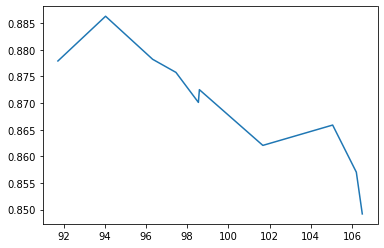

In [68]:
tolerance_accuracy={ key_:tolerance_accuracy[key_] for key_ in sorted(tolerance_accuracy)}
# print(tolerance_accuracy)
for tolerance_ in tolerance_accuracy:
  print(tolerance_,tolerance_accuracy[tolerance_])
from matplotlib import pyplot
pyplot.plot(list(tolerance_accuracy.keys()),list(tolerance_accuracy.values()))
pyplot.show()

In [7]:
def my_model_layersNtest1():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(32, activation = 'relu')(con)
  n_2 = tf.keras.layers.Dense(1)(n_1)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
def my_model_layersNtest2():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(20, activation = 'relu')(con)
  n_1_1 = tf.keras.layers.Dense(12, activation = 'relu')(n_1)
  n_2 = tf.keras.layers.Dense(1)(n_1_1)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
def my_model_layersNtest3():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(18, activation = 'relu')(con)
  n_1_1 = tf.keras.layers.Dense(9, activation = 'relu')(n_1)
  n_1_2 = tf.keras.layers.Dense(5, activation = 'relu')(n_1_1)
  n_2 = tf.keras.layers.Dense(1)(n_1_2)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
def my_model_layersNtest4():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(13, activation = 'relu')(con)
  n_1_1 = tf.keras.layers.Dense(10, activation = 'relu')(n_1)
  n_1_2 = tf.keras.layers.Dense(6, activation = 'relu')(n_1_1)
  n_1_3 = tf.keras.layers.Dense(3, activation = 'relu')(n_1_2)
  n_2 = tf.keras.layers.Dense(1)(n_1_3)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
def my_model_layersNtest5():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(12, activation = 'relu')(con)
  n_1_1 = tf.keras.layers.Dense(9, activation = 'relu')(n_1)
  n_1_2 = tf.keras.layers.Dense(6, activation = 'relu')(n_1_1)
  n_1_3 = tf.keras.layers.Dense(4, activation = 'relu')(n_1_2)
  n_1_4 = tf.keras.layers.Dense(2, activation = 'relu')(n_1_3)
  n_2 = tf.keras.layers.Dense(1)(n_1_4)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
models_layersNtest=[
  my_model_layersNtest1,
  my_model_layersNtest2,
  my_model_layersNtest3,
  my_model_layersNtest4,
  my_model_layersNtest5,
]

In [ ]:
for model_ in models_layersNtest:
  print('\n\n')
  model_().summary()

In [17]:
yystest_layersN_accuracy={}
yystest_layersN_accuracy_best={}
for model_method in models_layersNtest:
  model=model_method()
  layersN=len(model.layers)-5
  for cv in range(1, 6):
    print(f'layersN:{layersN}\tcv: {cv}')

    acc_t, ppg_t, label_t,  acc_v, ppg_v, label_v = split_data(new_acc, new_ppg,
    label,
    ratio = 0.8)

    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'MAE')
    model.fit([acc_t, ppg_t], label_t, batch_size = 32, epochs = 15)
    
    predict = model.predict([acc_v, ppg_v])
    v_error = mean_absolute_error(label_v, predict)

    sum_Er=0
    for i_ in range(len(predict)):
        d_=predict[i_][0]-label_v[i_]
        if d_ >0:
          sum_Er+=d_/label_v[i_]
        else:
          sum_Er-=d_/label_v[i_]
    accuracy_=1-(sum_Er/len(label_v))
    if layersN not in yystest_layersN_accuracy_best.keys() or yystest_layersN_accuracy_best[layersN]<accuracy_:
      yystest_layersN_accuracy_best[layersN]=accuracy_
      # yystest_paramsN_accuracy_best[paramsN]=accuracy_
    if layersN not in yystest_layersN_accuracy.keys():
      yystest_layersN_accuracy[layersN]=accuracy_
      # yystest_paramsN_accuracy[paramsN]=accuracy_
    else:
      yystest_layersN_accuracy[layersN]+=accuracy_
      # yystest_paramsN_accuracy[paramsN]+=accuracy_
    print("validation mean absolute error is : ", v_error)
    # print(f'layersN:{layersN}\tparamsN:{paramsN}\taccuracy:{accuracy_}')
    print(f'layersN:{layersN}\taccuracy:{accuracy_}')
    print('-----------------------\n\n')
  yystest_layersN_accuracy[layersN]/=5
  # yystest_paramsN_accuracy[paramsN]/=5

layersN:2	cv: 1
Epoch 1/15
116/116 [==============================] - 27s 204ms/step - loss: 73.8474
Epoch 2/15
116/116 [==============================] - 23s 201ms/step - loss: 23.6904
Epoch 3/15
116/116 [==============================] - 23s 201ms/step - loss: 13.9716
Epoch 4/15
116/116 [==============================] - 23s 200ms/step - loss: 11.6633
Epoch 5/15
116/116 [==============================] - 24s 204ms/step - loss: 11.1801
Epoch 6/15
116/116 [==============================] - 23s 199ms/step - loss: 10.5982
Epoch 7/15
116/116 [==============================] - 23s 200ms/step - loss: 10.9753
Epoch 8/15
116/116 [==============================] - 23s 202ms/step - loss: 9.9206
Epoch 9/15
116/116 [==============================] - 28s 239ms/step - loss: 10.9453
Epoch 10/15
116/116 [==============================] - 23s 201ms/step - loss: 10.4111
Epoch 11/15
116/116 [==============================] - 23s 200ms/step - loss: 11.3527
Epoch 12/15
116/116 [===========================

2 0.8789981462137904
3 0.8745076441035128
4 0.874340044150528
5 0.8786499225028738
6 0.8730283614055896


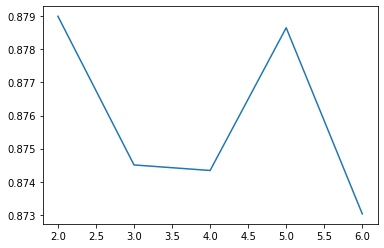

2 0.8959167663738292
3 0.8872970277769862
4 0.8846198766692551
5 0.88886337290656
6 0.885586404263187


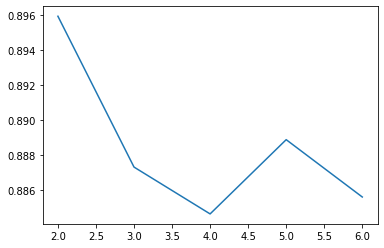

In [18]:
from matplotlib import pyplot
yystest_layersN_accuracy={ key_:yystest_layersN_accuracy[key_] for key_ in sorted(yystest_layersN_accuracy)}
for layersN_ in yystest_layersN_accuracy:
  print(layersN_,yystest_layersN_accuracy[layersN_])
pyplot.plot(list(yystest_layersN_accuracy.keys()),list(yystest_layersN_accuracy.values()))
pyplot.show()
print('====================================================================')
yystest_layersN_accuracy_best={ key_:yystest_layersN_accuracy_best[key_] for key_ in sorted(yystest_layersN_accuracy_best)}
for layersN_ in yystest_layersN_accuracy_best:
  print(layersN_,yystest_layersN_accuracy_best[layersN_])
pyplot.plot(list(yystest_layersN_accuracy_best.keys()),list(yystest_layersN_accuracy_best.values()))
pyplot.show()

In [10]:
def my_model_nodesNtest1():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(32, activation = 'relu')(con)
  n_2 = tf.keras.layers.Dense(1)(n_1)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
def my_model_nodesNtest2():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(64, activation = 'relu')(con)
  n_2 = tf.keras.layers.Dense(1)(n_1)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
def my_model_nodesNtest3():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(128, activation = 'relu')(con)
  n_2 = tf.keras.layers.Dense(1)(n_1)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
def my_model_nodesNtest4():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(256, activation = 'relu')(con)
  n_2 = tf.keras.layers.Dense(1)(n_1)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
def my_model_nodesNtest5():
  acc = tf.keras.Input(shape = (256, 3), name = 'acc_data_shape')
  ppg = tf.keras.Input(shape = (512, 1), name = 'ppg_data_shape')

  x1 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(acc)
  x2 = tf.keras.layers.LSTM(32, kernel_regularizer = tf.keras.regularizers.l1(l = 0.01),
                           kernel_initializer = 'he_uniform')(ppg)
  con = tf.keras.layers.concatenate([x1, x2])

  n_1 = tf.keras.layers.Dense(512, activation = 'relu')(con)
  n_2 = tf.keras.layers.Dense(1)(n_1)
  model = tf.keras.Model(inputs = [acc, ppg], outputs = n_2)
  return model
models_nodesNtest=[
  my_model_nodesNtest1,
  my_model_nodesNtest2,
  my_model_nodesNtest3,
  my_model_nodesNtest4,
  my_model_nodesNtest5,
]

In [11]:
for model_ in models_nodesNtest:
  print('\n\n')
  model_().summary()




Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
acc_data_shape (InputLayer)     [(None, 256, 3)]     0                                            
__________________________________________________________________________________________________
ppg_data_shape (InputLayer)     [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 32)           4608        acc_data_shape[0][0]             
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 32)           4352        ppg_data_shape[0][0]             
_________________________________________________________________________________________

In [12]:
yystest_paramsN_accuracy={}
yystest_paramsN_accuracy_best={}
for model_method in models_nodesNtest:
  model=model_method()
  paramsN=model.count_params()
  for cv in range(1, 6):
    print(f'paramsN:{paramsN}\tcv: {cv}')

    acc_t, ppg_t, label_t,  acc_v, ppg_v, label_v = split_data(new_acc, new_ppg,
    label,
    ratio = 0.8)

    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'MAE')
    model.fit([acc_t, ppg_t], label_t, batch_size = 32, epochs = 15)
    
    predict = model.predict([acc_v, ppg_v])
    v_error = mean_absolute_error(label_v, predict)

    sum_Er=0
    for i_ in range(len(predict)):
        d_=predict[i_][0]-label_v[i_]
        if d_ >0:
          sum_Er+=d_/label_v[i_]
        else:
          sum_Er-=d_/label_v[i_]
    accuracy_=1-(sum_Er/len(label_v))
    if paramsN not in yystest_paramsN_accuracy_best.keys() or yystest_paramsN_accuracy_best[paramsN]<accuracy_:
      # yystest_layersN_accuracy_best[layersN]=accuracy_
      yystest_paramsN_accuracy_best[paramsN]=accuracy_
    if paramsN not in yystest_paramsN_accuracy.keys():
      # yystest_layersN_accuracy[layersN]=accuracy_
      yystest_paramsN_accuracy[paramsN]=accuracy_
    else:
      # yystest_layersN_accuracy[layersN]+=accuracy_
      yystest_paramsN_accuracy[paramsN]+=accuracy_
    print("validation mean absolute error is : ", v_error)
    # print(f'layersN:{layersN}\tparamsN:{paramsN}\taccuracy:{accuracy_}')
    print(f'paramsN:{paramsN}\taccuracy:{accuracy_}')
    print('-----------------------\n\n')
  # yystest_layersN_accuracy[layersN]/=5
  yystest_paramsN_accuracy[paramsN]/=5

paramsN:11073	cv: 1
Epoch 1/15
116/116 [==============================] - 26s 197ms/step - loss: 73.5468
Epoch 2/15
116/116 [==============================] - 23s 197ms/step - loss: 24.3162
Epoch 3/15
116/116 [==============================] - 23s 197ms/step - loss: 14.5247
Epoch 4/15
116/116 [==============================] - 23s 196ms/step - loss: 14.1799
Epoch 5/15
116/116 [==============================] - 23s 198ms/step - loss: 13.5426
Epoch 6/15
116/116 [==============================] - 23s 195ms/step - loss: 13.1488
Epoch 7/15
116/116 [==============================] - 23s 201ms/step - loss: 13.0819
Epoch 8/15
116/116 [==============================] - 23s 196ms/step - loss: 12.5943
Epoch 9/15
116/116 [==============================] - 23s 199ms/step - loss: 12.4901
Epoch 10/15
116/116 [==============================] - 23s 198ms/step - loss: 12.1164
Epoch 11/15
116/116 [==============================] - 23s 196ms/step - loss: 11.8797
Epoch 12/15
116/116 [======================

11073 0.8603311286298757
13185 0.8754554348463912
17409 0.8732060940928321
25857 0.867020034879
42753 0.8863131831306305


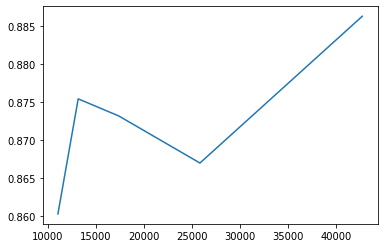

11073 0.8725809645391157
13185 0.8865676217622971
17409 0.8843172258082472
25857 0.8882897331162418
42753 0.8932444252746135


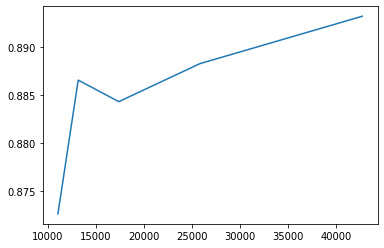

In [14]:
from matplotlib import pyplot
yystest_paramsN_accuracy={ key_:yystest_paramsN_accuracy[key_] for key_ in sorted(yystest_paramsN_accuracy)}
for paramsN_ in yystest_paramsN_accuracy:
  print(paramsN_,yystest_paramsN_accuracy[paramsN_])
pyplot.plot(list(yystest_paramsN_accuracy.keys()),list(yystest_paramsN_accuracy.values()))
pyplot.show()
print('====================================================================')
yystest_paramsN_accuracy={ key_:yystest_paramsN_accuracy_best[key_] for key_ in sorted(yystest_paramsN_accuracy_best)}
for paramsN_ in yystest_paramsN_accuracy_best:
  print(paramsN_,yystest_paramsN_accuracy_best[paramsN_])
pyplot.plot(list(yystest_paramsN_accuracy_best.keys()),list(yystest_paramsN_accuracy_best.values()))
pyplot.show()